In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading data into dataframe
df = pd.read_csv("data/planets.csv")
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [3]:
# The dataset contains planet data, and a label which indicated whether or not it is a candidate to be a habitable planet.
# If it is a candidate, it needs to be manually reviewed, and will be either confirmed, or labeled a false positive.
# Our goal is to use data science techniques to autimate the review process (or attempt to).

# Steps to take:
# - Preprocessing: We must make sure that we only have cases where the review has been done. This way we can make sure that the AI is trained on accurate data.
# - Preprocessing: We must label the data, so that on our y axis, we can classify between habitable and unhabitable (0 or 1).
# - Model building: We must build different models, using different classification techniques, to determine the bitability of each planet.
# - Training: We must train different models, and adjust training according to the evaluation of the training.
# - Evaluating: We will measure the performance and training of each model, and adjust accordingly.
# - Presentation: We will try to visualize the results in such a way, that a human can easily understand it.

In [4]:
# Preprocessing: Removing irrelevant data

columns_to_drop = ["rowid", "kepid", "kepoi_name", "kepler_name", "koi_tce_delivname", "koi_fpflag_ec", "koi_duration", "koi_slogg", "koi_kepmag", "koi_slogg_err2", "koi_steff_err1", "koi_model_snr", "koi_impact", "koi_impact_err1", "koi_time0bk"]

#FAIL !!!
# koi_fpflag_ec
# koi_duration
# koi_slogg
# koi_kepmag
# koi_slogg_err2
# koi_steff_err1
# koi_model_snr
# koi_impact

# We remove these columns becuase sklearn cannot 

# Reduce performance
# koi_impact_err1
# koi_time0bk


df = df.drop(columns=columns_to_drop, axis=1)

# Removing CANDIDATE DATA, becaus we only want the planets that are checked
df = df[df["koi_disposition"] != "CANDIDATE"]
print(df.columns)

Index(['koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt',
       'koi_fpflag_ss', 'koi_fpflag_co', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2',
       'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2',
       'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad',
       'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1',
       'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec'],
      dtype='object')


In [5]:
# Preprocessing: Normalizing the data
columns_to_normalize = ['koi_fpflag_nt',
       'koi_fpflag_ss', 'koi_fpflag_co', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2',
       'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2',
       'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad',
       'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1',
       'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec']

df[columns_to_normalize] = df[columns_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [6]:
# Dropping unused column, because we are already hot-one-encoding the pdisposition field, and have removed all the CANDIDATE's
df = df.drop(columns=["koi_disposition", "koi_score", "koi_teq_err1", "koi_teq_err2"], axis=1)
df = df.fillna(0)
# We will also hot-one-encode the koi_disposition column, because we can then compare the score to the encoding, and determine the certainty.
for i, r in df.iterrows():
    if r["koi_pdisposition"] == "CANDIDATE":
        df.at[i, "koi_pdisposition"] = 1
    else:
        df.at[i, "koi_pdisposition"] = 0


In [7]:
# Preprocessing: Labeling the data
# We split the data into tnto x and y (features and lables)
y_cols = ["koi_pdisposition"]
y = df[y_cols]
x = df.drop(columns=y_cols, axis=1)

# Transforming the dataset to numpy array's, so that we have lower level control over the object.
x = x.to_numpy()
y = y.to_numpy()

In [8]:
# Here we split the x and y into training and test datasets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=2020)

In [9]:
# this function takes a classifier and all the data, it will then use that classifyer to perform a classification on the planets.
# Afterwards it will print how many were correct, and how accuracte it was.
def perform_measure(classifyer, x_train, y_train, x_test, y_test):
    classifyer = classifyer.fit(x_train, y_train)
    y_pred = classifyer.predict(x_test)

    # y_test = y_test.reshape((-1,))

    correct = 0

    for i in range(len(y_test)):
        pred = y_pred[i]
        actual = y_test[i]

        if pred == actual:
            correct += 1

    print(f"Correct: {correct}")
    print(f"Total: {len(y_test)}")
    accuracy = correct / len(y_test)
    print(f"Accuracy: {accuracy}")
    return accuracy


metrics = []

metrics.append(perform_measure(DummyClassifier(strategy="most_frequent"), x_train, y_train, x_test, y_test))
metrics.append(perform_measure(DummyClassifier(strategy="stratified"), x_train, y_train, x_test, y_test))
metrics.append(perform_measure(DummyClassifier(strategy="prior"), x_train, y_train, x_test, y_test))
metrics.append(perform_measure(DummyClassifier(strategy="uniform"), x_train, y_train, x_test, y_test))


Correct: 1011
Total: 1464
Accuracy: 0.6905737704918032
Correct: 839
Total: 1464
Accuracy: 0.5730874316939891
Correct: 1011
Total: 1464
Accuracy: 0.6905737704918032
Correct: 721
Total: 1464
Accuracy: 0.4924863387978142


In [10]:
# We use categorical NB classifier to determine whether a planet is habitable or not
nb = CategoricalNB()
nb = nb.fit(x, y.astype("int"))
y_hat = nb.predict(x)
score = nb.score(x, y.astype("int"))
metrics.append(score)
print(f'Accuracy: {score}')
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

# We can see that the model is quite good at prdicting the habitability of planets, and has an accuracy of 96%
# This is significantly better than the dummy classifyers

Accuracy: 0.9667851284855112
Confusion Matrix: [[4836  232]
 [  11 2237]]


In [11]:
# We can also use different classifiers than categorical Naive Bayes
# In this cell we will use the support vector machine
print("########### LINEAR Kernel ###########")
machine = SVC(kernel="linear")
machine.fit(x, y.astype("int"))
y_hat = machine.predict(x)
score = machine.score(x, y.astype("int"))
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

# This classifier performs slightly better than the naive bayes classifier, with a score of 97.5%
# We can also check if the poly or rbf kernels outperform the linear kernel

print("########### POLY Kernel ###########")
machine = SVC(kernel="poly")
machine.fit(x, y.astype("int"))
y_hat = machine.predict(x)
score = machine.score(x, y.astype("int"))
metrics.append(score)
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

print("########### RBF Kernel ###########")
machine = SVC(kernel="rbf")
machine.fit(x, y.astype("int"))
y_hat = machine.predict(x)
score = machine.score(x, y.astype("int"))
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

# As you can see, the best performing kernel is the poly kernel, so we are going to use this in our metrics
# For some reason all kernels get the same amount of false negatives.
# We also get around 170 false positives, which is pretty good, considering the dataset contains almost 5000 planets.

########### LINEAR Kernel ###########
Accuracy: 0.9752597047566977
Confusion Matrix: [[4898  170]
 [  11 2237]]
########### POLY Kernel ###########
Accuracy: 0.9763531984691088
Confusion Matrix: [[4906  162]
 [  11 2237]]
########### RBF Kernel ###########
Accuracy: 0.9748496446145435
Confusion Matrix: [[4895  173]
 [  11 2237]]


In [12]:
# In this cell we are going to use the KNN classifier, and we will see how well this performs
from sklearn.neighbors import KNeighborsClassifier

print("########### AUTO Algorithm ###########")
knn = KNeighborsClassifier(algorithm="auto")
knn.fit(x, y.astype("int"))
y_hat = knn.predict(x)
score = knn.score(x, y.astype("int"))
metrics.append(score)
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

print("########### BALL TREE Algorithm ###########")
knn = KNeighborsClassifier(algorithm="ball_tree")
knn.fit(x, y.astype("int"))
y_hat = knn.predict(x)
score = knn.score(x, y.astype("int"))
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

print("########### KD TREE Algorithm ###########")
knn = KNeighborsClassifier(algorithm="kd_tree")
knn.fit(x, y.astype("int"))
y_hat = knn.predict(x)
score = knn.score(x, y.astype("int"))
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

print("########### BRUTE Algorithm ###########")
knn = KNeighborsClassifier(algorithm="brute")
knn.fit(x, y.astype("int"))
y_hat = knn.predict(x)
score = knn.score(x, y.astype("int"))
print(f"Accuracy: {score}")
print(f'Confusion Matrix: {confusion_matrix(y.astype("int"), y_hat.astype("int"))}')

# All the KNN algorithms results in the same metrics.
# So we're going to add the auto algorithm to the metrics array

########### AUTO Algorithm ###########
Accuracy: 0.9830508474576272
Confusion Matrix: [[4959  109]
 [  15 2233]]
########### BALL TREE Algorithm ###########
Accuracy: 0.9830508474576272
Confusion Matrix: [[4959  109]
 [  15 2233]]
########### KD TREE Algorithm ###########
Accuracy: 0.9830508474576272
Confusion Matrix: [[4959  109]
 [  15 2233]]
########### BRUTE Algorithm ###########
Accuracy: 0.9830508474576272
Confusion Matrix: [[4959  109]
 [  15 2233]]


In [13]:
# In the above image we can see how accurate we are in predicting the habitability of planets.
# We see each type of classigication method an the different results.
# In order to work with keras we need to transform our data into numpy arrays

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

np.save("models/datasets/planets_x_train", x_train)
np.save("models/datasets/planets_x_test", x_test)
np.save("models/datasets/planets_y_train", y_train.reshape((-1, 1)))
np.save("models/datasets/planets_y_test", y_test.reshape((-1, 1)))


(5852, 30)
(1464, 30)
(5852, 1)
(1464, 1)


Train on 5852 samples, validate on 1464 samples
Epoch 1/3
5852/5852 [==============================] - 1s 217us/step - loss: 0.4756 - accuracy: 0.7708 - val_loss: 0.1664 - val_accuracy: 0.9754
Epoch 2/3
5852/5852 [==============================] - 1s 202us/step - loss: 0.1231 - accuracy: 0.9718 - val_loss: 0.0824 - val_accuracy: 0.9761
Epoch 3/3
5852/5852 [==============================] - 1s 117us/step - loss: 0.0927 - accuracy: 0.9745 - val_loss: 0.0833 - val_accuracy: 0.9761
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________

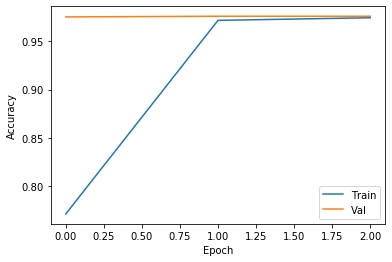

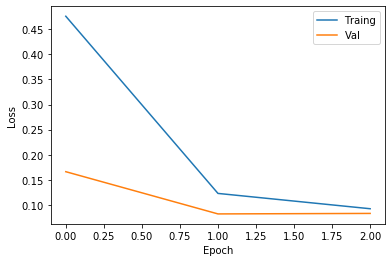

In [14]:
# The KNN classifier has the highest accuracy, out of the orthodox classifiers (98.3%)
# On second place comes the Support Vector Machine, with (97.6%)
# Last place is for the Naive Bayes Classifier, with (96.6%)
# We will attempt to build a Deep Neural Network, which outerpforms any orthodox classifier

# Load dataset from hard drive
x_train = np.load("models/datasets/planets_x_train.npy")
x_test = np.load("models/datasets/planets_x_test.npy")
y_test = np.load("models/datasets/planets_y_test.npy", allow_pickle=True)
y_train = np.load("models/datasets/planets_y_train.npy", allow_pickle=True)


# We create a new sequential model
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

arr_metrics = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

model.summary()

####### NAME #########
model.save("models/networks/small_model3.h5", model)
######################

evaluation = model.evaluate(x_test, y_test)
print("Validation Loss, Validation Accuracy")
print(evaluation)

print(arr_metrics.history.keys())
plt.plot(arr_metrics.history["accuracy"])
plt.plot(arr_metrics.history["val_accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"])
plt.show()

plt.plot(arr_metrics.history["loss"])
plt.plot(arr_metrics.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Traing", "Val"])
plt.show()


In [15]:
# As you can see the model has a validation loss of 0.08 and an accuracy of 0.98
# After 3 epochs the accuracy does not increase anymore.
# We can now evaluate all planets using the predict() method

model = load_model("models/networks/small_model2.h5")

print(x.shape)
print(y.shape)
print(x[0].shape)


print("Predicting planets...")
# We are looping here through the entire dataset.
# We use our model to predict each planet, and based on the corresponding label we determine if the prediction is correct.
# We are checking if the difference between the actual value, 0 or 1, is smaller than 0.5.
# If that is the case we made a correct prediction
# Else our prediction is wrong, and gets printed to the screen
correct = 0


for i in range(len(x)):
    xi = x[i]
    xi = xi.reshape((-1,30))
    pred = model.predict(xi)
    actual = y[i]

    if abs(actual - pred) < 0.5:
        correct += 1
        
acc = correct / len(x)
print(f"Correct: {correct}, Accuracy: {acc}")
metrics.append(acc)


(7316, 30)
(7316, 1)
(30,)
Predicting planets...
Correct: 7139, Accuracy: 0.9758064516129032


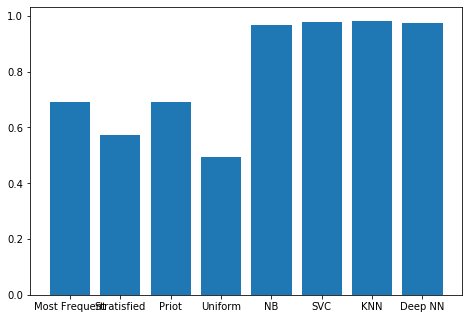

In [16]:
# Here we can see how well each classifier performs
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
types = ["Most Frequent", "Stratisfied", "Priot", "Uniform", "NB", "SVC", "KNN", "Deep NN"]
ax.bar(types, metrics)
plt.show()

In [17]:
# The AI we built has an over-all accuracy of 98%, which is not the best classifier. KNN has the highest score of all classification methods.
# The AI is still very good at predicting the habitability of the kepler planets.
# In the future, as more planets are added to the data set, the KNN classifier could be used to determine the habitability of these planets.